<a href="https://colab.research.google.com/github/OleksandrArtemenko/ab_testing_frequentist_and_bayesian_portfolio/blob/main/ab_testing_frequentist_and_bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Вступ

Цей проект має на меті опис підходів до визначення умов та оцінювання результатів А/В тестів.
На сьогоднішній день, у відкритих джерелах виділяється здебільшого два підходи:


*   Частотний підхід - більш традиційний, відзначається чіткою формалізацією умов проведення тесту, а саме: визначення прийнятних величин помилок 1-го та 2-го роду, що у свою чергу втілюється у прийнятті рішення щодо мінімальної кількості показів для кожної групи і тривалості тесту, а також більш чіткі рамки прийняття рішень;
*   Байєсівський підхід - більш гнучкий і, у більшості випадків, більш доступний для розуміння у плані інтерпретації результатів. На відміну від частотного підходу, при якому рекомендується проведення всього тесту для отримання обгрунтованих висновків, більше підходить для динамічного прийняття рішень.



#Основна частина дослідження

##Завантаження даних

In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import beta


np.random.seed(38)

In [ ]:
plt.style.use('seaborn-v0_8')

In [ ]:
# #Завантаження даних напряму з BigQuery
# #Для завантаження даних напряму з BigQuery Public Datasets необхідно мати Google Account, а також створений проект у BigQuery (він може бути пустим).
# #Можна створити проект з тим же ім'ям, яке вказано у змінній PROJECT_NAME, або ж замінити його на свою назву.
# from google.colab import auth
# from google.cloud import bigquery

# auth.authenticate_user()
# PROJECT_NAME = "ab-testing-public-datasets"
# client = bigquery.Client(project=PROJECT_NAME)

# query = """
# SELECT
#   fullVisitorId AS user_id,
#   device.deviceCategory AS device,
#   geoNetwork.country AS country,
#   trafficSource.medium AS medium,
#   IF(totals.newVisits = 1, 'new', 'returning') AS user_type,
#   MAX(IF(totals.transactions > 0, 1, 0)) AS converted
# FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
# WHERE _TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
# GROUP BY
#   user_id, device, country, medium, user_type
# """
# df = client.query(query).to_dataframe()

In [ ]:
#Завантаження даних з Google Drive
url = "https://drive.google.com/uc?id=1DHYwDMDnECvml7D7zBVaCguRToVw7O9v"
df = pd.read_csv(url)

In [ ]:
df.head()

,user_id,device,country,medium,user_type,converted
0,2631948857389837129,desktop,Ireland,(none),new,0
1,1399781354314532773,desktop,Canada,organic,new,0
2,8497228714350538778,desktop,Spain,(none),returning,0
3,8881180193700914216,desktop,Switzerland,organic,new,0
4,6722124103691282794,desktop,Finland,organic,new,0


In [ ]:
df.shape

(65383, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65383 entries, 0 to 65382
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    65383 non-null  object
 1   device     65383 non-null  object
 2   country    65383 non-null  object
 3   medium     65383 non-null  object
 4   user_type  65383 non-null  object
 5   converted  65383 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 3.0+ MB


In [ ]:
df['converted'].value_counts(normalize=True)*100

,proportion
converted,
0,98.502669
1,1.497331


In [ ]:
baseline_CR = 0.015

Провівши огляд даних, ми бачимо їх успішний імпорт та відсутність пропущених значень. Окрім цього, ми бачимо рівень конверсії у даній вибірці, який приймаємо за базовий рівень.

##Частотний підхід у проведенні А/В тестів

Для початку, напишемо функцію визначення мінімального розміру вибірки для кожної групи. Для цього основними показниками будуть базова конверсія, величина мінімального ефекту, який хочемо побачити, а також величини помилок 1-го та 2-го роду.

In [ ]:
def required_sample_size(
    baseline_cr,
    mde,
    alpha=0.05,
    power=0.8,
    relative=True
):

    if relative:
        delta = baseline_cr * mde
    else:
        delta = mde

    p1 = baseline_cr
    p2 = baseline_cr + delta

    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)

    pooled_var = p1 * (1 - p1) + p2 * (1 - p2)

    n = ((z_alpha + z_beta) ** 2 * pooled_var) / (delta ** 2)

    return math.ceil(n)

Перевіримо роботу функції для відносного зростання базової конверсії на 20%.

In [ ]:
mde = 0.2
sample_size_02_mde = required_sample_size(baseline_cr=baseline_CR, mde=mde)
print(sample_size_02_mde)

28301


Також додатково перевіримо роботу функції із різними аргументами - при збільшенні мінімально потрібного ефекту обсяг має зменшуватись, а при зменшенні рівня помилок 1-го та 2-го роду - збільшуватись.

In [ ]:
mde = 0.3
required_sample_size(baseline_cr=baseline_CR, mde=mde)

13138

In [ ]:
mde = 0.2
alpha = 0.01
power = 0.9
required_sample_size(baseline_cr=baseline_CR, mde=mde, alpha=alpha, power=power)

53651

Після цього, напишемо функцію, яка рандомізує групи для наявного датасету. Якщо задавати у якості аргументу параметр n_per_group, то на виході матимемо датасет відповідного розміру (n_per_group * 2).

In [ ]:
def sample_and_assign_groups(df, n_per_group=None):

    if n_per_group is None:
        n_per_group = len(df) // 2

    total_needed = 2 * n_per_group

    if len(df) < total_needed:
        raise ValueError(
            f"У наявних даних недостатньо значень: "
            f"Потрібно: {total_needed}, наявно: {len(df)}"
        )


    df_sample = df.sample(
        n=total_needed,
        replace=False
    ).copy()

    groups = np.array(["A"] * n_per_group + ["B"] * n_per_group)
    np.random.shuffle(groups)

    df_sample["group"] = groups

    return df_sample

Перевіримо роботу функції для минулого прикладу.

In [ ]:
df_sample_02_mde = sample_and_assign_groups(df, n_per_group=sample_size_02_mde)
df_sample_02_mde.head()

,user_id,device,country,medium,user_type,converted,group
33661,9295075885587213129,mobile,United Kingdom,organic,new,0,B
64326,6622161244934752871,desktop,United States,(none),returning,0,A
29016,8404854171490730515,desktop,United Kingdom,organic,new,0,A
55956,7375388599118719624,mobile,United States,organic,new,0,B
8529,1558801725154523717,desktop,United States,cpc,new,0,B


In [ ]:
df_sample_02_mde["group"].value_counts()

,count
group,
B,28301
A,28301


Далі, напишемо функцію корегування конверсії тестової групи В. Це потрібно для того, щоб перевірити роботу системи оцінювання результатів тесту, тобто отримати дані з відомою нам "ground truth".

In [ ]:
def apply_uplift(
    df,
    baseline_cr,
    uplift,
    relative=True,
):

    p_A = baseline_cr

    if relative:
        p_B = baseline_cr * (1 + uplift)
    else:
        p_B = baseline_cr + uplift

    df = df.copy()

    mask_A = df["group"] == "A"
    mask_B = ~mask_A

    df.loc[mask_A, "converted"] = np.random.binomial(
        1, p_A, size=mask_A.sum()
    )
    df.loc[mask_B, "converted"] = np.random.binomial(
        1, p_B, size=mask_B.sum()
    )

    return df


Отже, ми отримуємо функцію, яка дозволяє нам отримувати результати із приблизно заданим приростом (випадковий фактор продовжує існувати, тому результати кожного запуску можуть дещо відрізнятися один від одного).
Перевіримо роботу функції, задавши відносний приріст у конверсії на рівні 20%.

In [ ]:
df_sample_02_mde_02_uplift = apply_uplift(df_sample_02_mde, baseline_cr=baseline_CR, uplift=0.2)

df_sample_02_mde_02_uplift.groupby("group")["converted"].mean()

,converted
group,
A,0.014558
B,0.018056


Оскільки результати для окремого запуску варіюються, зробимо симуляцію на 1000 випадків.
У результаті отримуємо цифри, близькі до очікуваних у теорії (0.015 та 0.018).

In [ ]:
means_A = []
means_B = []

for _ in range(1000):
    df_sim = apply_uplift(df_sample_02_mde, baseline_cr=baseline_CR, uplift=0.2)
    means_A.append(df_sim[df_sim["group"]=="A"]["converted"].mean())
    means_B.append(df_sim[df_sim["group"]=="B"]["converted"].mean())

print(np.mean(means_A))
print(np.mean(means_B))

0.015006360199286245
0.017977032613688566


Далі, напишемо функцію проведення одного тесту.

In [ ]:
def frequentist_ab_test(df, alpha=0.05):
    summary = (
        df.groupby("group")["converted"]
        .agg(["sum", "count"])
    )

    s_A, n_A = summary.loc["A"]
    s_B, n_B = summary.loc["B"]

    p_A = s_A / n_A
    p_B = s_B / n_B

    uplift = (p_B - p_A) / p_A

    p_pool = (s_A + s_B) / (n_A + n_B)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n_A + 1/n_B))

    z = (p_B - p_A) / se
    p_value = 2 * (1 - norm.cdf(abs(z)))

    ci_low = uplift - 1.96 * se / p_A
    ci_high = uplift + 1.96 * se / p_A

    return {
        "cr_A": p_A,
        "cr_B": p_B,
        "uplift": uplift,
        "z_stat": z,
        "p_value": p_value,
        "significant": p_value < alpha,
        "ci_uplift": (ci_low, ci_high)
    }

Протестуємо проведення одного тесту. В результаті, отримуємо p_value на меншому рівні, ніж визначені 5%, що дає нам підстави відхилити нульову гіпотезу про те, що між групами немає різниці.

In [ ]:
frequentist_ab_test(df_sample_02_mde_02_uplift)

{'cr_A': 0.014557789477403625,
 'cr_B': 0.01805589908483799,
 'uplift': 0.2402912621359223,
 'z_stat': np.float64(3.285523056461354),
 'p_value': np.float64(0.0010179321099557104),
 'significant': np.True_,
 'ci_uplift': (np.float64(0.0969439577059047), np.float64(0.3836385665659399))}

На завершення, напишемо функцію, щоб подивитися на симуляцію результатів багатьох тестів (поставимо значення за замовченням у 1000 симуляцій).

In [ ]:
def monte_carlo_frequentist(
    df,
    baseline_cr,
    uplift,
    n_runs=1000
):
    results = []

    for _ in range(n_runs):
        df_sim = apply_uplift(
            df,
            baseline_cr=baseline_cr,
            uplift=uplift,
            relative=True
        )
        res = frequentist_ab_test(df_sim)

        results.append({
            "uplift_hat": res["uplift"],
            "p_value": res["p_value"],
            "significant": res["significant"]
        })

    return pd.DataFrame(results)

Перевіримо роботу функції та отримуємо результат, який буде близьким до теоретичного 0.8, тобто до величини потужності тесту, який визначався нами ще при формуванні вимог до мінімального розміру груп.

In [ ]:
mc02 = monte_carlo_frequentist(
    df_sample_02_mde,
    baseline_cr=baseline_CR,
    uplift=0.2,
)

print(f'Частка статистично значущих результатів: {mc02["significant"].mean()}')
print(f'Середня величина різниці між групами: {mc02["uplift_hat"].mean()}')

Частка статистично значущих результатів: 0.798
Середня величина різниці між групами: 0.20135266193726056


Також, в ілюстративних цілях, побудуємо графіки розподілу ключових показників тесту у розрізі симуляцій.

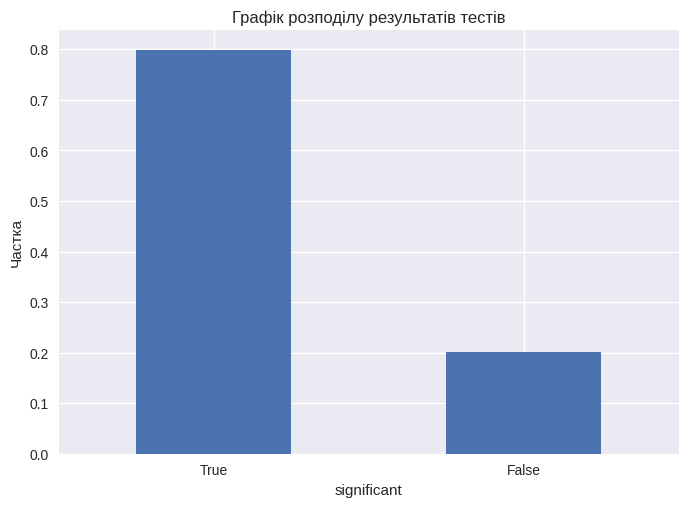

In [ ]:
counts = mc02["significant"].value_counts(normalize=True)

plt.figure()
counts.plot(kind="bar")
plt.ylabel("Частка")
plt.title("Графік розподілу результатів тестів")
plt.xticks(rotation=0)
plt.show()

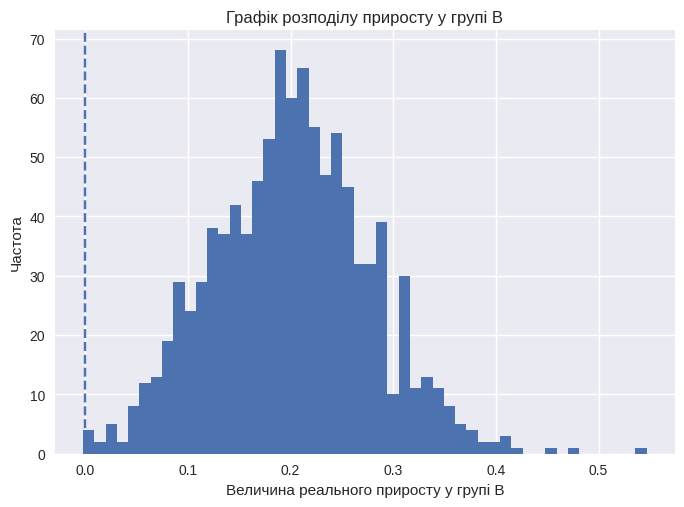

In [ ]:
plt.figure()
plt.hist(mc02["uplift_hat"], bins=50)
plt.axvline(0, linestyle="--")
plt.xlabel("Величина реального приросту у групі В")
plt.ylabel("Частота")
plt.title("Графік розподілу приросту у групі В")
plt.show()

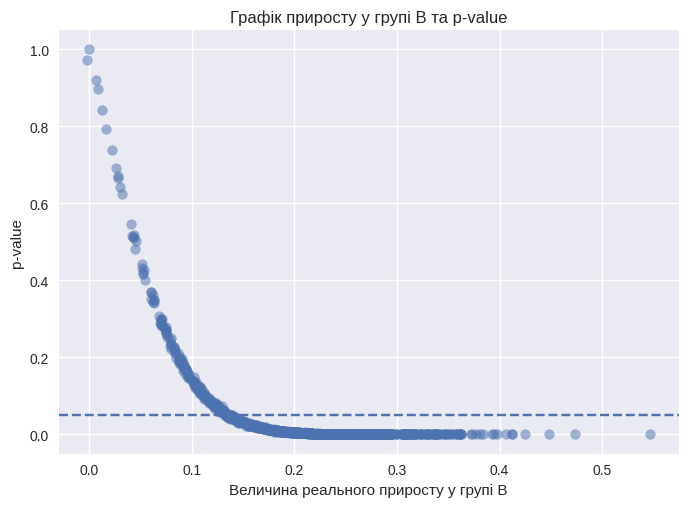

In [ ]:
plt.figure()
plt.scatter(mc02["uplift_hat"], mc02["p_value"], alpha=0.5)
plt.axhline(0.05, linestyle="--")
plt.xlabel("Величина реального приросту у групі В")
plt.ylabel("p-value")
plt.title("Графік приросту у групі В та p-value")
plt.show()

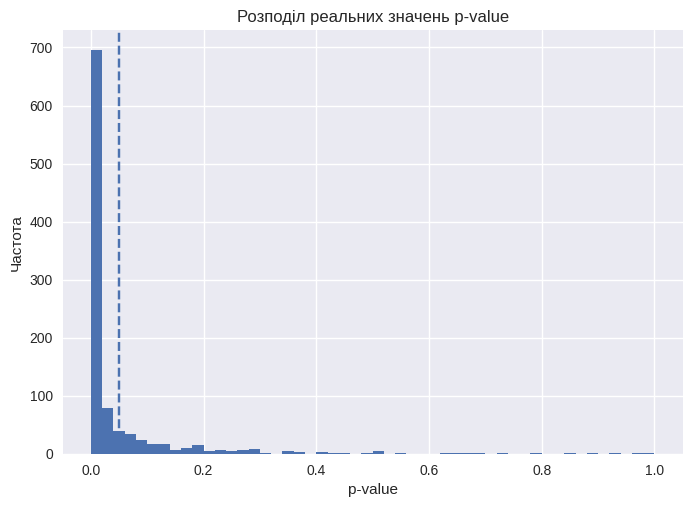

In [ ]:
plt.figure()
plt.hist(mc02["p_value"], bins=50)
plt.axvline(0.05, linestyle="--")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.title("Розподіл реальних значень p-value")
plt.show()

У результаті реалізації частотного A/B тесту в рамках Monte Carlo симуляції було отримано функціонал, який дозволяє оцінювати ймовірність відхилення нульової гіпотези за заздалегідь заданого рівня статистичної значущості та потужності тесту.

Зокрема, у випадках, коли фактична різниця між групами A та B відповідає очікуваній величині ефекту (MDE), закладеній на етапі дизайну експерименту, тест відхиляє нульову гіпотезу з частотою, що узгоджується з теоретичною потужністю тесту.

Окрім цього, перевіримо роботу алгоритму для випадків, коли різниці у групах немає, або коли результати групи В гірші, ніж у групи А.

Перевірка, коли між групами немає різниці:

In [ ]:
mc0 = monte_carlo_frequentist(
    df_sample_02_mde,
    baseline_cr=baseline_CR,
    uplift=0,
)

print(f'Частка статистично значущих результатів: {mc0["significant"].mean()}')
print(f'Середня величина різниці між групами: {mc0["uplift_hat"].mean()}')

Частка статистично значущих результатів: 0.046
Середня величина різниці між групами: 0.002585807890290939


Отже, ми бачимо, що значення близьке до теоретичного 5% (величина помилки 1-го роду).

Також проведемо тест для випадків, де конверсія у групі В є нижчою.

In [ ]:
mc_minus02 = monte_carlo_frequentist(
    df_sample_02_mde,
    baseline_cr=baseline_CR,
    uplift=-0.2,
)

print(f'Частка статистично значущих результатів: {mc_minus02["significant"].mean()}')
print(f'Середня величина різниці між групами: {mc_minus02["uplift_hat"].mean()}')

Частка статистично значущих результатів: 0.875
Середня величина різниці між групами: -0.199330005931095


Як бачимо, при негативній зміні цільового показника частка значущих тестів навіть збільшується (це відбувається через використання дисперсії пулу прирозрахунку стандартної помилки), але це навіть приносить користь у даному випадку, оскільки у більшій кількості випадків будуть підстави для ідентифікації зміни між варіантами А і В як негативної.

##Байєсівський підхід у проведенні А/В тестів

Тепер напишемо функції для байєсівського аналізу А/В тестування.

Перша функція оновлює розподіл можливих значень конверсії.

In [ ]:
def beta_posterior_params(successes, trials, alpha_prior=1, beta_prior=1):
    return (
        alpha_prior + successes,
        beta_prior + trials - successes
    )

Наступна функція оцінює вірогідність різниці між групами за допомогою багаторазових вибірок із розподілів конверсій.

In [ ]:
def prob_B_greater_A(
    alpha_A, beta_A,
    alpha_B, beta_B,
    n_samples=100_000
):
    samples_A = np.random.beta(alpha_A, beta_A, n_samples)
    samples_B = np.random.beta(alpha_B, beta_B, n_samples)
    return np.mean(samples_B > samples_A)

Далі пишемо функцію для проведення одного тесту для заданого датасету.

In [ ]:
def bayesian_ab_test(
    df,
    alpha_prior=1,
    beta_prior=1,
    n_samples=100_000
):
    df_A = df[df["group"] == "A"]
    df_B = df[df["group"] == "B"]

    n_A = len(df_A)
    n_B = len(df_B)

    x_A = df_A["converted"].sum()
    x_B = df_B["converted"].sum()

    alpha_A, beta_A = beta_posterior_params(
        x_A, n_A, alpha_prior, beta_prior
    )
    alpha_B, beta_B = beta_posterior_params(
        x_B, n_B, alpha_prior, beta_prior
    )

    p_B_gt_A = prob_B_greater_A(
        alpha_A, beta_A,
        alpha_B, beta_B,
        n_samples
    )

    return {
        "n_A": n_A,
        "n_B": n_B,
        "conv_A": x_A,
        "conv_B": x_B,
        "p_B_gt_A": p_B_gt_A,
        "alpha_A": alpha_A,
        "beta_A": beta_A,
        "alpha_B": alpha_B,
        "beta_B": beta_B
    }


Після цього, наступна функція є певною оптимізацією минулої, оскільки призначена для перевірки вірогідності того, чи тестова група є кращою за контрольну, кожну задану кількість спостережень.

In [ ]:
def bayesian_sequential_test(
    df,
    check_every=1000,
    decision_threshold=0.95,
    alpha_prior=1,
    beta_prior=1,
    n_samples=100_000
):
    n_max = (
        df
        .groupby("group")
        .size()
        .min()
    )

    checkpoints = range(
        check_every,
        n_max + 1,
        check_every
    )

    last_res = None

    for n in checkpoints:
        df_slice = (
            df
            .groupby("group", group_keys=False)
            .head(n)
        )

        res = bayesian_ab_test(
            df_slice,
            alpha_prior=alpha_prior,
            beta_prior=beta_prior,
            n_samples=n_samples
        )

        last_res = res
        p = res["p_B_gt_A"]

        if p >= decision_threshold:
            return {
                "decision": "B wins",
                "n_stop": n,
                "p_B_gt_A": p,
                "result": res
            }

        if p <= 1 - decision_threshold:
            return {
                "decision": "A wins",
                "n_stop": n,
                "p_B_gt_A": p,
                "result": res
            }

    return {
        "decision": "Inconclusive",
        "n_stop": n_max,
        "p_B_gt_A": last_res["p_B_gt_A"],
        "result": last_res
    }


Спробуємо провести один тест.

In [ ]:
df_ab_bayesian = sample_and_assign_groups(df)
df_ab_bayesian_uplift_02 = apply_uplift(df_ab_bayesian, baseline_cr=baseline_CR, uplift=0.2)

In [ ]:
res = bayesian_sequential_test(
    df_ab_bayesian_uplift_02,
    check_every=1000,
    decision_threshold=0.95
)

In [ ]:
print(res["decision"])
print(res["n_stop"])
print(res["p_B_gt_A"])

B wins
8000
0.96426


Отже, ми отримали результат одного тесту, але для більш повного бачення потрібно побачити, як система оцінки працює для великої кількості симуляцій.

In [ ]:
def monte_carlo_bayesian_sequential(
    df,
    baseline_cr,
    uplift,
    n_runs=1000,
    relative=True,
    check_every=1000,
    decision_threshold=0.95,
    alpha_prior=1,
    beta_prior=1
):
    results = []

    for i in range(n_runs):

        df_ab = sample_and_assign_groups(df)

        df_ab = apply_uplift(
            df_ab,
            baseline_cr=baseline_cr,
            uplift=uplift,
            relative=relative
        )

        res = bayesian_sequential_test(
            df_ab,
            check_every=check_every,
            decision_threshold=decision_threshold,
            alpha_prior=alpha_prior,
            beta_prior=beta_prior
        )

        results.append({
            "run": i,
            "decision": res["decision"],
            "n_stop": res["n_stop"],
            "p_B_gt_A": res["p_B_gt_A"]
        })

    return pd.DataFrame(results)


Отже, тепер перевіримо, як алгоритм працює для 300 симуляцій (ставимо не 1000, як раніше, оскільки обчислення результатів є більш затратним по часу).

In [ ]:
mc_bayes_02 = monte_carlo_bayesian_sequential(
    df,
    baseline_cr=baseline_CR,
    uplift=0.2,
    n_runs=300,
    check_every=1000,
    decision_threshold=0.95
)

print(f"Перемагає варіант В: {(mc_bayes_02["decision"] == "B wins").mean()}")
print(f"Перемагає варіант А: {(mc_bayes_02["decision"] == "A wins").mean()}")
print(f"Результат невизначений: {(mc_bayes_02["decision"] == "Inconclusive").mean()}")

Перемагає варіант В: 0.9233333333333333
Перемагає варіант А: 0.03
Результат невизначений: 0.04666666666666667


Отже, ми бачимо, що алгоритм добре працює для випадків, де варіант В дійсно кращий за А, показуючи результат вищий 90%.

In [ ]:
mc_bayes_02["n_stop"].describe()

,n_stop
count,300.000000
mean,9655.580000
std,9050.906419
min,1000.000000
25%,2000.000000
50%,6000.000000
75%,14250.000000
max,32691.000000


Також, необхідно зобразити розподіл розмірності даних, достатніх для прийняття рішень.

In [ ]:
def plot_stopping_distribution(mc_bayes):
    data = mc_bayes["n_stop"].dropna()

    plt.figure()
    plt.hist(data, bins=30)
    plt.xlabel("n_stop (кількість спостережень на момент зупинки)")
    plt.ylabel("Кількість симуляцій")
    plt.title("Розподіл моменту зупинки Bayesian sequential A/B тесту")

    plt.axvline(data.median(), color='red', linestyle='--')

    plt.show()

    print(f"Медіана зупинки: {data.median()}")

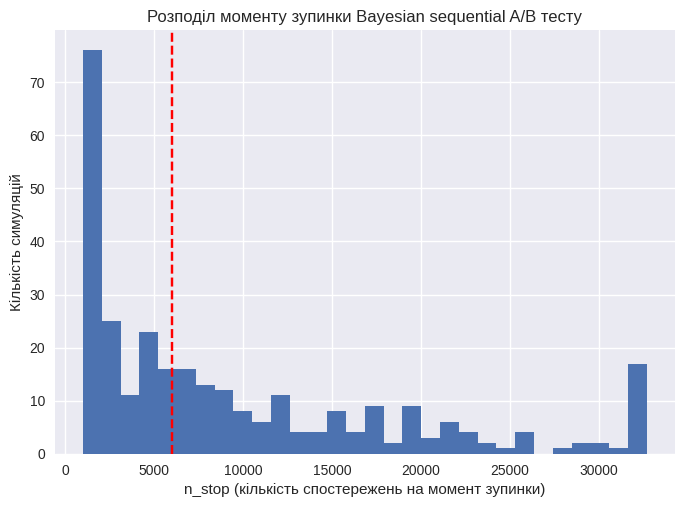

Медіана зупинки: 6000.0


In [ ]:
plot_stopping_distribution(mc_bayes_02)

Бачимо, що рішення переважно приймається вже після 1000 спостережень для кожної групи, а медіанне значення є суттєво нижчим за аналогічне для частотного періоду.

Далі перевіримо роботу алгоритму для випадків, коли різниці між групами немає, або коли контрольна група краще за тестову.

Різниця відсутня:

Перемагає варіант В: 0.21
Перемагає варіант А: 0.23333333333333334
Результат невизначений: 0.5566666666666666


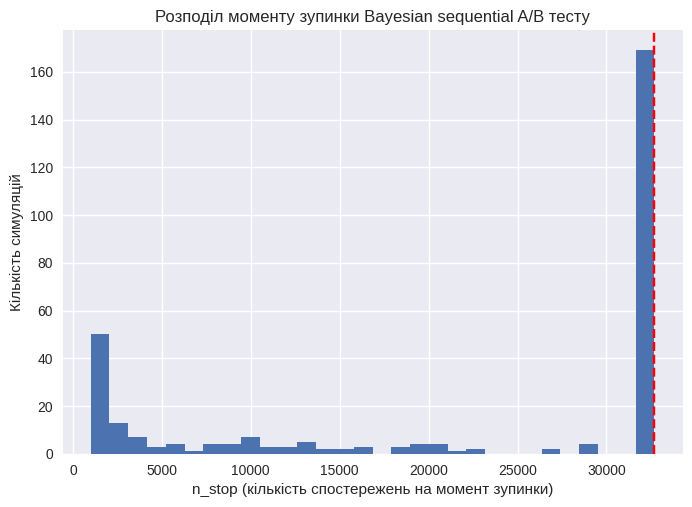

Медіана зупинки: 32691.0


In [ ]:
mc_bayes_0 = monte_carlo_bayesian_sequential(
    df,
    baseline_cr=baseline_CR,
    uplift=0,
    n_runs=300,
    check_every=1000,
    decision_threshold=0.95
)

print(f"Перемагає варіант В: {(mc_bayes_0["decision"] == "B wins").mean()}")
print(f"Перемагає варіант А: {(mc_bayes_0["decision"] == "A wins").mean()}")
print(f"Результат невизначений: {(mc_bayes_0["decision"] == "Inconclusive").mean()}")

plot_stopping_distribution(mc_bayes_0)

Контрольна група краща за тестову:

Перемагає варіант В: 0.016666666666666666
Перемагає варіант А: 0.9633333333333334
Результат невизначений: 0.02


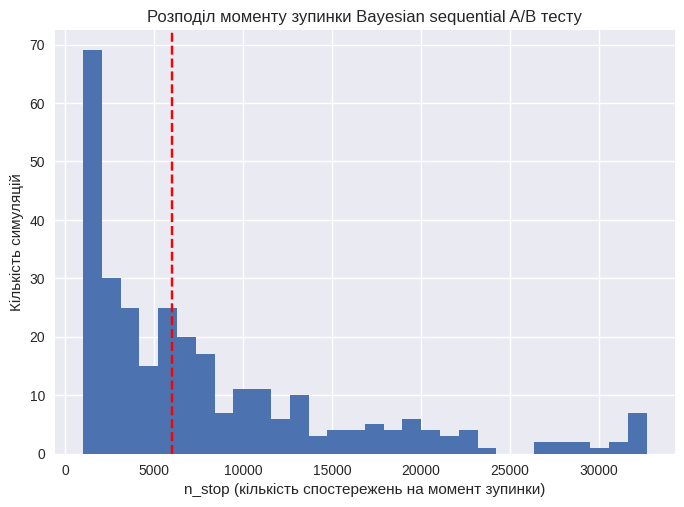

Медіана зупинки: 6000.0


In [ ]:
mc_bayes_minus02 = monte_carlo_bayesian_sequential(
    df,
    baseline_cr=baseline_CR,
    uplift=-0.2,
    n_runs=300,
    check_every=1000,
    decision_threshold=0.95
)

print(f"Перемагає варіант В: {(mc_bayes_minus02["decision"] == "B wins").mean()}")
print(f"Перемагає варіант А: {(mc_bayes_minus02["decision"] == "A wins").mean()}")
print(f"Результат невизначений: {(mc_bayes_minus02["decision"] == "Inconclusive").mean()}")

plot_stopping_distribution(mc_bayes_minus02)

Отже, ми бачимо, що у даному вигляді алгоритм добре розрізняє ситуації, коли існує різниця між групами, і робить це з вищою точністю, ніж частотний алгоритм.
Однак, наявна проблема із випадками, коли групи не мають різниці - у приблизно половині випадків алгоритм все ж визнає А чи В переможцем, і це може дати неправильні уявлення про ефект різниці між А і В, а отже і про продукт в цілому.

Щоб уникнути цього, спробуємо оптимізувати функцію, мінімізувавши врахування практично незначущого ефекту, а також змінивши деякі гіперпараметри функцій (початковий розподіл та поріг для прийняття рішень).

Перемагає варіант В: 0.07
Перемагає варіант А: 0.06666666666666667
Результат невизначений: 0.8633333333333333


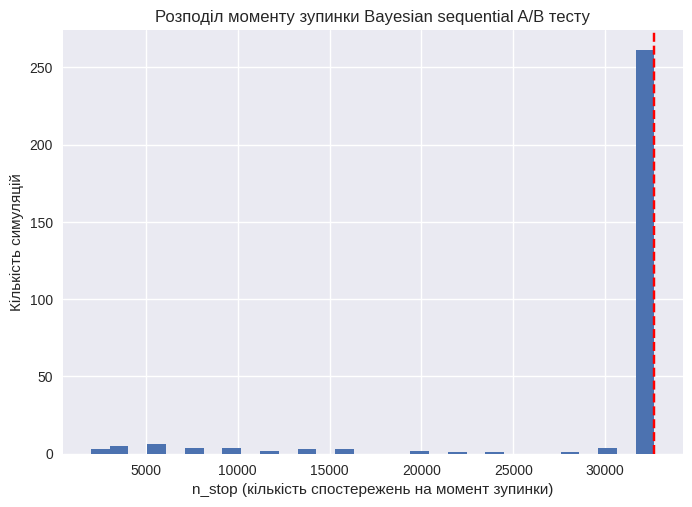

Медіана зупинки: 32691.0


In [ ]:
mc_bayes_0 = monte_carlo_bayesian_sequential(
    df,
    baseline_cr=baseline_CR,
    uplift=0,
    n_runs=300,
    check_every=2000,
    decision_threshold=0.98,
    alpha_prior=20,
    beta_prior=20
)

print(f"Перемагає варіант В: {(mc_bayes_0["decision"] == "B wins").mean()}")
print(f"Перемагає варіант А: {(mc_bayes_0["decision"] == "A wins").mean()}")
print(f"Результат невизначений: {(mc_bayes_0["decision"] == "Inconclusive").mean()}")

plot_stopping_distribution(mc_bayes_0)

Отже, можемо побачити більш надійну роботу для груп без різниці, коли більшість тестів залишаються невизначеними. Тепер перевіримо роботу функції із даними гіперпараметрами для випадків, коли та чи інша група переважає.

Перемагає варіант В: 0.8733333333333333
Перемагає варіант А: 0.0033333333333333335
Результат невизначений: 0.12333333333333334


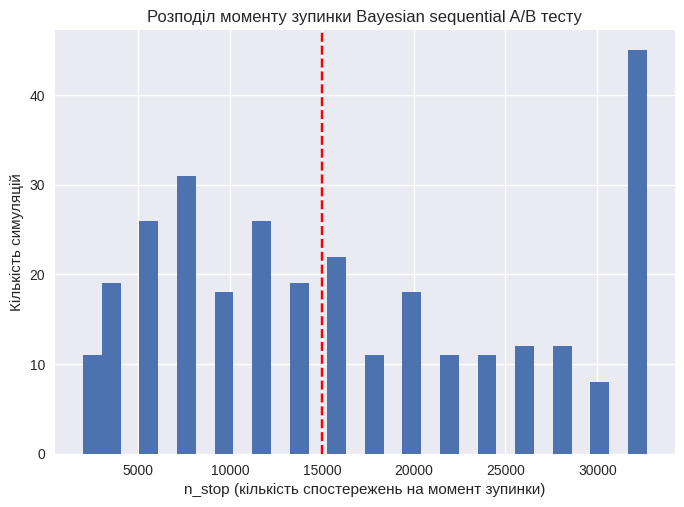

Медіана зупинки: 15000.0


In [ ]:
mc_bayes_02 = monte_carlo_bayesian_sequential(
    df,
    baseline_cr=baseline_CR,
    uplift=0.2,
    n_runs=300,
    check_every=2000,
    decision_threshold=0.98,
    alpha_prior=20,
    beta_prior=20
)

print(f"Перемагає варіант В: {(mc_bayes_02["decision"] == "B wins").mean()}")
print(f"Перемагає варіант А: {(mc_bayes_02["decision"] == "A wins").mean()}")
print(f"Результат невизначений: {(mc_bayes_02["decision"] == "Inconclusive").mean()}")

plot_stopping_distribution(mc_bayes_02)

Перемагає варіант В: 0.0
Перемагає варіант А: 0.91
Результат невизначений: 0.09


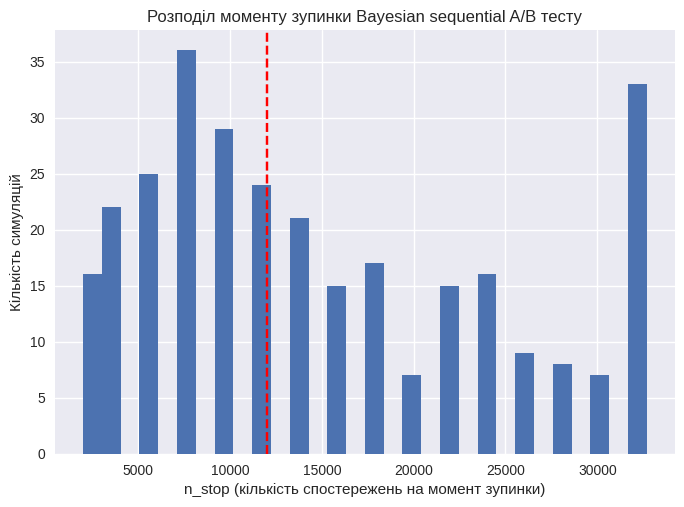

Медіана зупинки: 12000.0


In [ ]:
mc_bayes_minus02 = monte_carlo_bayesian_sequential(
    df,
    baseline_cr=baseline_CR,
    uplift=-0.2,
    n_runs=300,
    check_every=2000,
    decision_threshold=0.98,
    alpha_prior=20,
    beta_prior=20
)

print(f"Перемагає варіант В: {(mc_bayes_minus02["decision"] == "B wins").mean()}")
print(f"Перемагає варіант А: {(mc_bayes_minus02["decision"] == "A wins").mean()}")
print(f"Результат невизначений: {(mc_bayes_minus02["decision"] == "Inconclusive").mean()}")

plot_stopping_distribution(mc_bayes_minus02)

#Висновки

##Висновки стосовно проведених експериментів



1.   Загалом, проведене дослідження роботи двох підходів (частотного та байєсівського) до проведення та оцінювання результатів А/В тестів  на одному датасеті.
2.   Було досліджено 3 сценарії різниці у конверсіях між групами:

*   Тестова група має вищу конверсію на 20% відносно контрольної;
*   Різниця між конверсіями відсутня;
*   Тестова група має нижчу конверсію на 20% відносно контрольної.
3.   Результати для частотного підходу виявилися близькими до теоретичних - від 80% значущих результатів для випадків різниці між групами та близько 5% значущих результатів у випадках, коли у групах немає різниці.
4.   Результати для байєсівсього підходу показали приріст відносно частотного у ситуаціях, коли переважає одна з груп - приріст порядку 5-10% в залежності від сценарію. У той же час, для сценарію рівних конверсій байєсівський алгоритм надає перевагу одному із варіантів у більшій кількості симуляцій (12-14% відносно приблизно 5% у частотному підході). Також слід відмітити, що за наявності більших обчислювальних потужностей можливий кращий підбір гіперпараметрів або взагалі оптимізація для байєсівського алгоритму, що могло б підвищити його точність для сценаріїв із рівними конверсіями.
5.   Байєсівський підхід значно раніше виявляє кращу групу - необхідний розмір групи знизився приблизно у 2 рази - з 28301 у частотному до 12000-15000 у байєсівському.


##Загальні висновки стосовно розглянутих підходів до проведення А/В тестів

1. При виборі алгоритму для використання потрібно, звичайно, враховувати якомога більше факторів діяльності компанії і того, на якому етапі розвитку вона перебуває.
2. З точки зору інтерпретації результатів, байєсівський підхід є більш доступним, оскільки прямо дає інформацію про вірогідність переваги одного варіанту над іншим.
3. З іншої сторони, частотний підхід передбачає більш стабільну та консервативну структуру дослідження.
4. Будь-який підхід, скоріш за все, даватиме непослідовні результати у випадку, якщо поведінка клієнтів не буде незалежною (наприклад, наявність мережевого ефекту або всплески попиту під час свят і таке інше).
5. Бізнесам, які тільки починають свою діяльність, часто притаманна проблематика недостатності даних - для них байєсівський підхід у проведенні А/В тестів може стати хорошим рішенням, оскільки він не містить застережень стосовно мінімального розміру груп, справа тільки у виборі рівня вірогідності, достатнього для прийняття рішення.